In [2]:
#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
## save the preprocessed data
merged_train_df = pd.read_csv('./data/train_preprocessed_month_lbw.csv')
merged_test_df = pd.read_csv('./data/test_preprocessed_month_lbw.csv')
merged_train_df = merged_train_df.drop(columns = 'Unnamed: 0')
merged_test_df = merged_test_df.drop(columns = 'Unnamed: 0')

final_train_df = pd.read_csv('./data/final_train_preprocessed_month_lbw.csv')
merged_valid_df = pd.read_csv('./data/valid_preprocessed_month_lbw.csv')
merged_semi_train_df = pd.read_csv('./data/semi_train_preprocessed_month_lbw.csv')
merged_pretest_df = pd.read_csv('./data/pretest_preprocessed_month_lbw.csv')
merged_pretest_df = merged_pretest_df.drop(columns='Unnamed: 0')
merged_semi_train_df = merged_semi_train_df.drop(columns='Unnamed: 0')
final_train_df = final_train_df.drop(columns = 'Unnamed: 0')
merged_valid_df = merged_valid_df.drop(columns = 'Unnamed: 0')

In [6]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

bnum_list = [3,14,18,19,30,42,53,54,80,82,83,88,89,90,91,92,95,98]

In [5]:
df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 12, 1),
        'max_depth' : np.arange(3,10,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
        'subsample' :np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)

#tscv = TimeSeriesSplit(n_splits=3)
smape_score = make_scorer(SMAPE, greater_is_better=False)

#bnum = 14
bnum_list = [3,14,18,19,30,42,53,54,80,82,83,88,89,90,91,92,95,98]
for i, bnum in enumerate(bnum_list):
        y_train = merged_semi_train_df.loc[merged_semi_train_df.building_number == bnum, 'power_consumption']
        x_train = merged_semi_train_df.loc[merged_semi_train_df.building_number == bnum].drop(['power_consumption'], axis=1)
        y_valid = merged_pretest_df.loc[merged_pretest_df.building_number == bnum, 'power_consumption']
        x_valid = merged_pretest_df.loc[merged_pretest_df.building_number == bnum].drop(['power_consumption'], axis=1)

        pds = PredefinedSplit(np.append(-np.ones(len(x_train)-168), np.zeros(168)))
        gcv = GridSearchCV(estimator = XGBRegressor(seed=0,tree_method="hist"),
                        param_grid=grid, scoring=smape_score, cv=pds, refit=True, verbose=True)

        gcv.fit(x_train, y_train)
        best = gcv.best_estimator_
        params = gcv.best_params_
        print(params)
        pred = best.predict(x_valid)
        building = 'building'+str(bnum)
        print(building + '|| SMAPE : {}'.format(SMAPE(y_valid, pred)))
        preds = np.append(preds, pred)
        df = pd.concat([df, pd.DataFrame(params, index=[0])], axis=0)
        df.to_csv('./parameters/hyperparameter_month_18_lbw.csv', index=False) # save the tuned parameters

Fitting 1 folds for each of 308 candidates, totalling 308 fits
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.8}
building3|| SMAPE : 36.55765566314448
Fitting 1 folds for each of 308 candidates, totalling 308 fits
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building14|| SMAPE : 39.382187706303945
Fitting 1 folds for each of 308 candidates, totalling 308 fits
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
building18|| SMAPE : 48.47610807791757
Fitting 1 folds for each of 308 candidates, totalling 308 fits
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
building19|| SMAPE : 49.46336262448942
Fitting 1 folds for each of 308 candidates, totalling 308 fits
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min

In [6]:
xgb_params_before = pd.read_csv('./parameters/hyperparameter_month_18_lbw.csv')

In [7]:

scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list

#bnum = 14
for i, bnum in enumerate(bnum_list):
    y_train = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
    x_train = merged_train_df.loc[merged_train_df.building_number == bnum].drop(['power_consumption'], axis=1)
    y_valid = merged_valid_df.loc[merged_valid_df.building_number == bnum, 'power_consumption']
    x_valid = merged_valid_df.loc[merged_valid_df.building_number == bnum].drop(['power_consumption'], axis=1)
    y_pretest = merged_pretest_df.loc[merged_pretest_df.building_number == bnum, 'power_consumption']
    x_pretest = merged_pretest_df.loc[merged_pretest_df.building_number == bnum].drop(['power_consumption'], axis=1)

    xgb_reg = XGBRegressor(seed=0,tree_method="hist", 
                            n_estimators = 10000, eta = 0.01, min_child_weight = xgb_params_before.iloc[i,2],
                            max_depth = xgb_params_before.iloc[i,3], colsample_bytree = xgb_params_before.iloc[i,4],
                            subsample = xgb_params_before.iloc[i,5])
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)

    y_pred = xgb_reg.predict(x_pretest)
    pred = pd.Series(y_pred)

    sm = SMAPE(y_pretest, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration) ## 실제 best iteration은 이 값에 +1 해주어야 함.

In [8]:
alpha_list = []
smape_list = []

#bnum = 14
for i, bnum in enumerate(bnum_list):
    y_train = merged_semi_train_df.loc[merged_semi_train_df.building_number == bnum, 'power_consumption']
    x_train = merged_semi_train_df.loc[merged_semi_train_df.building_number == bnum].drop(['power_consumption'], axis=1)
    y_valid = merged_pretest_df.loc[merged_pretest_df.building_number == bnum, 'power_consumption']
    x_valid = merged_pretest_df.loc[merged_pretest_df.building_number == bnum].drop(['power_consumption'], axis=1)

    xgb = XGBRegressor(seed=0,tree_method="hist",
                        n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params_before.iloc[i, 2],
                        max_depth = xgb_params_before.iloc[i, 3], colsample_bytree = xgb_params_before.iloc[i, 4], subsample = xgb_params_before.iloc[i, 5])

    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_valid)
    best_alpha = 0
    score0 = SMAPE(y_valid,pred0)

    #for j in np.arange(1,100,2):
    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed=0,tree_method="hist",
                        n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params_before.iloc[i, 2],
                        max_depth = xgb_params_before.iloc[i, 3], colsample_bytree = xgb_params_before.iloc[i, 4], subsample = xgb_params_before.iloc[i, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})

        xgb.fit(x_train, y_train)
        pred1 = xgb.predict(x_valid)
        score1 = SMAPE(y_valid, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(bnum, score0, best_alpha))


building 3 || best score : 11.594854308305207 || alpha : 1
building 14 || best score : 16.010413353878608 || alpha : 0
building 18 || best score : 10.183523356197709 || alpha : 50
building 19 || best score : 14.554127032812822 || alpha : 75
building 30 || best score : 11.131426837024168 || alpha : 75
building 42 || best score : 10.9700357578248 || alpha : 0
building 53 || best score : 12.252285004943742 || alpha : 75
building 54 || best score : 34.729539729344225 || alpha : 25
building 80 || best score : 15.947396195906741 || alpha : 50
building 82 || best score : 12.72971736989109 || alpha : 50
building 83 || best score : 12.300198425066258 || alpha : 25
building 88 || best score : 14.545721298991037 || alpha : 50
building 89 || best score : 11.090452316793172 || alpha : 100
building 90 || best score : 12.242417435451834 || alpha : 7
building 91 || best score : 12.926212062021996 || alpha : 10
building 92 || best score : 11.444599638838362 || alpha : 3
building 95 || best score : 14.5

In [9]:
xgb_params_before['alpha'] = alpha_list
xgb_params_before['best_it'] = best_it
xgb_params_before.to_csv('./parameters/hyperparameter_month_18_lbw.csv', index=False)

In [5]:
xgb_params = pd.read_csv('./parameters/hyperparameter_month_18_lbw.csv')


In [ ]:

preds = np.array([])
scores=[]
missfit_building=[]

# bnum = 14
for i, bnum in enumerate(bnum_list):
    pred_df = pd.DataFrame()
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = merged_semi_train_df.loc[merged_semi_train_df.building_number == bnum, 'power_consumption']
        x_train = merged_semi_train_df.loc[merged_semi_train_df.building_number == bnum].drop(['power_consumption'], axis=1)
        y_valid = merged_pretest_df.loc[merged_pretest_df.building_number == bnum, 'power_consumption']
        x_valid = merged_pretest_df.loc[merged_pretest_df.building_number == bnum].drop(['power_consumption'], axis=1)

        xgb_reg = XGBRegressor(n_estimators = xgb_params.iloc[i,7], eta = xgb_params.iloc[i,1], min_child_weight = xgb_params.iloc[i,2], 
                            max_depth = xgb_params.iloc[i,3], colsample_bytree = xgb_params.iloc[i,4], 
                            subsample = xgb_params.iloc[i,5], seed=seed)
        if xgb_params.iloc[i,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
                    xgb_reg.set_params(**{'objective':weighted_mse(xgb_params.iloc[i,6])})



        #xgb_reg.set_params(**{'objective':weighted_mse(100)})
        xgb_reg.fit(x_train, y_train)

        pred = xgb_reg.predict(x_valid)
        pred_df.loc[:,seed] = pred

    
    pred = pred_df.mean(axis=1)
    pred = pd.Series(pred)
    pred_np = pred.to_numpy()
    y_valid_np = y_valid.to_numpy()
    score = SMAPE(y_valid_np, pred_np)
    plus_index = y_train.index[-1]
    pred.index = np.arange(y_valid.index[0]+plus_index, y_valid.index[-1]+plus_index+1)
    y_valid.index = np.arange(y_valid.index[0]+plus_index, y_valid.index[-1]+plus_index+1)
    plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

    scores.append(score)
    preds = np.append(preds, pred)
    missfit_building = np.append(missfit_building, bnum)

    print(bnum)
    print('best iterations: {}'.format(xgb_reg.best_iteration))
    print('SMAPE : {}'.format(SMAPE(y_valid, pred)))


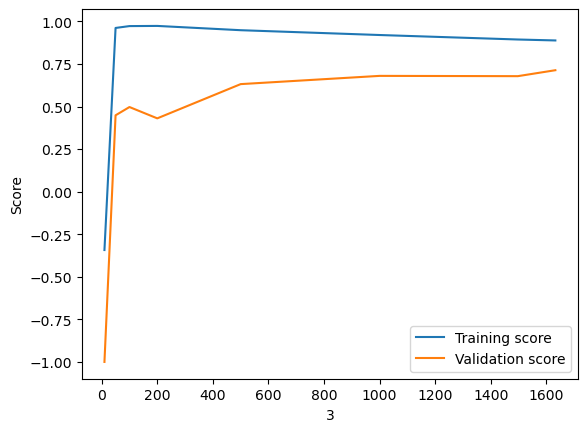

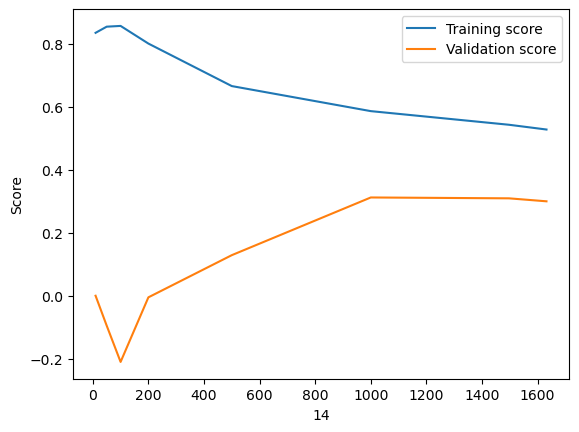

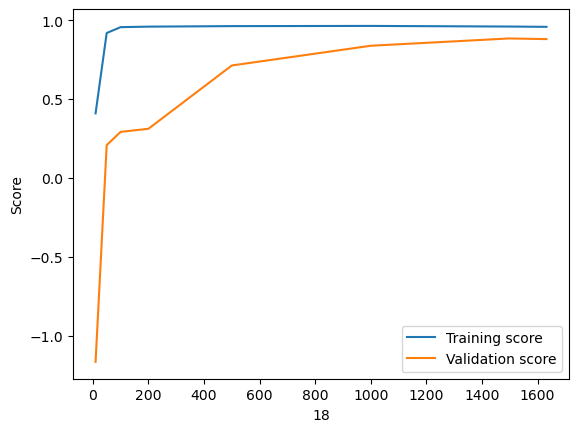

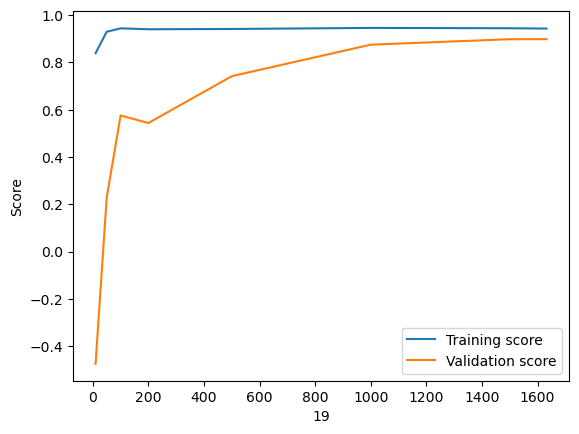

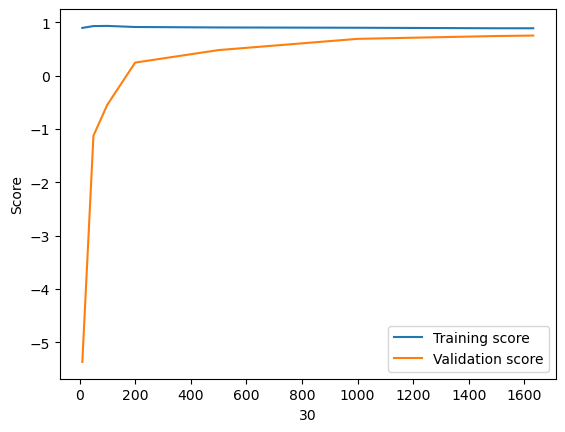

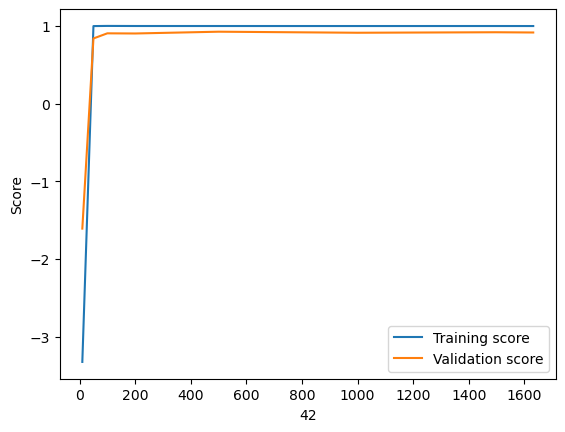

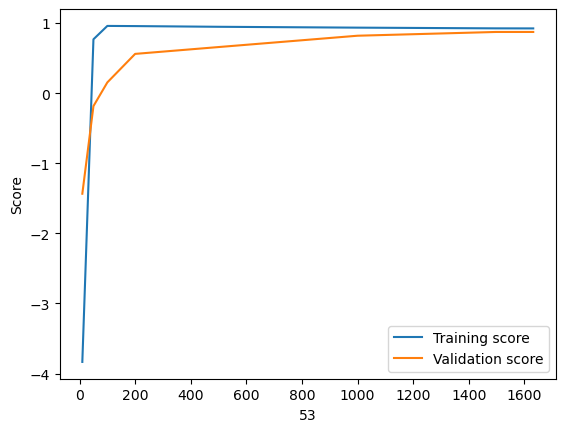

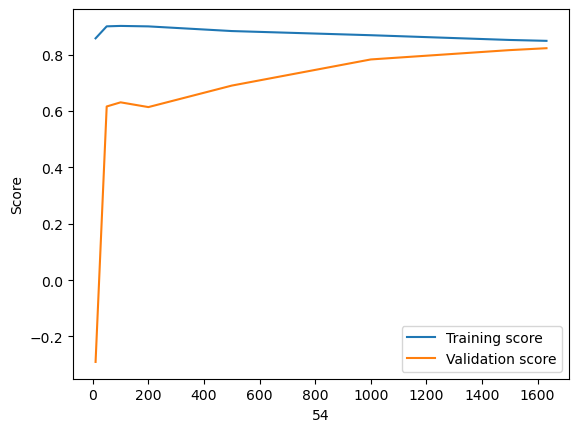

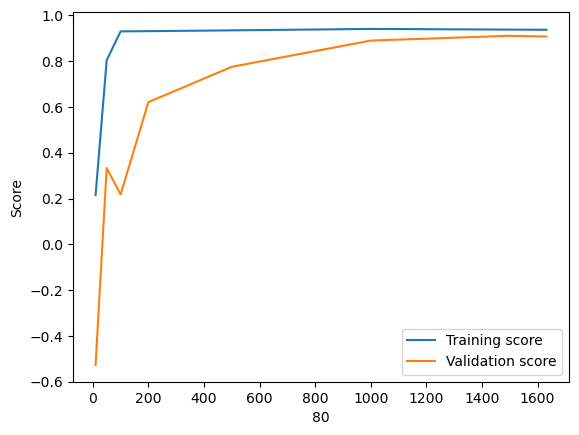

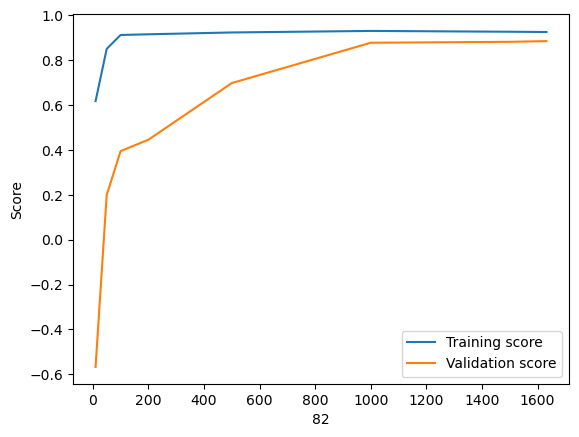

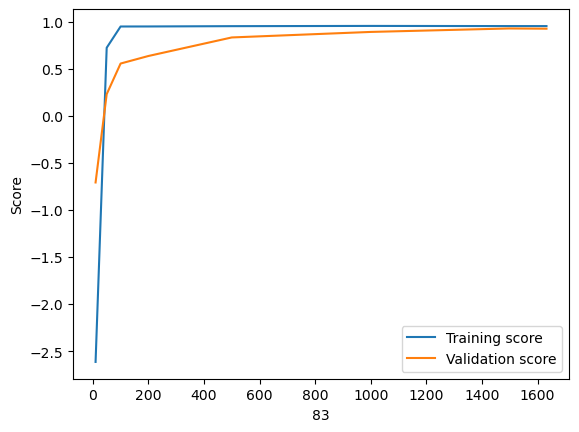

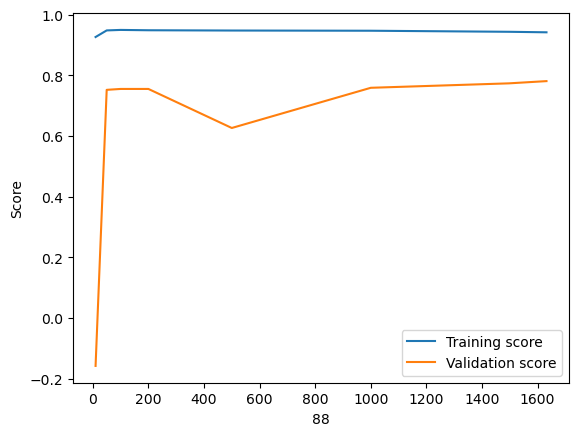

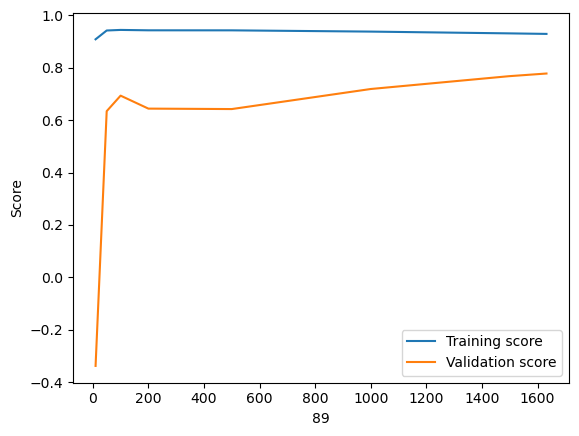

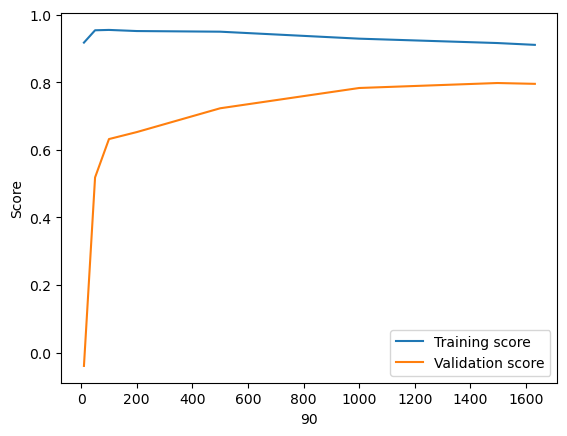

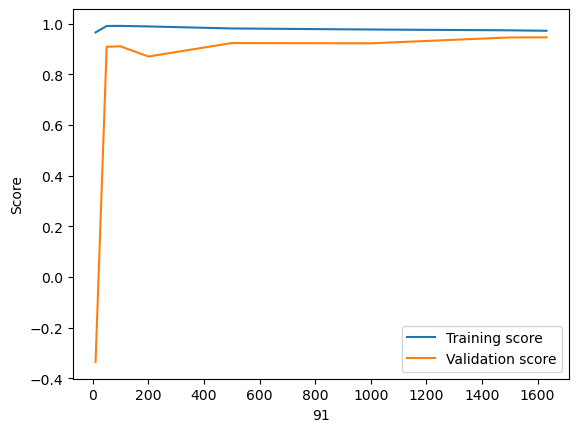

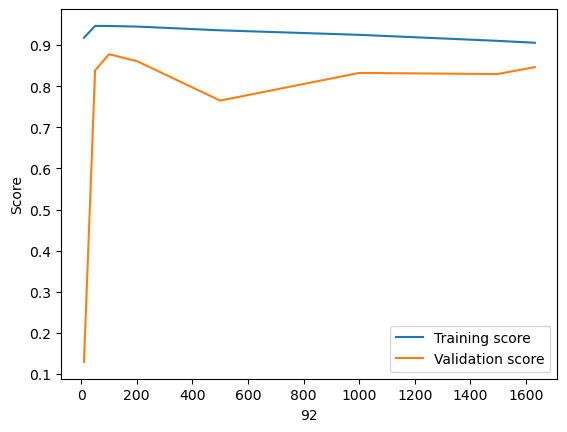

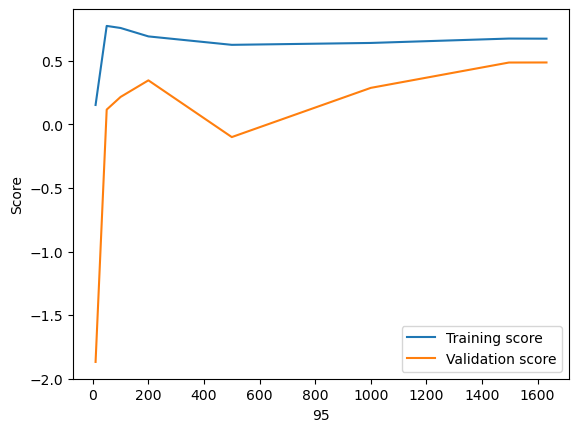

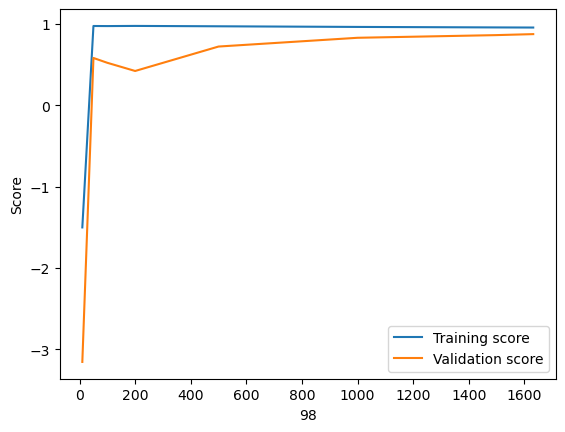

In [8]:
from sklearn.model_selection import learning_curve

# i = 7
# bnum=54
for i, bnum in enumerate(bnum_list):
    y_train = final_train_df.loc[final_train_df.building_number == bnum, 'power_consumption']
    x_train = final_train_df.loc[final_train_df.building_number == bnum].drop(['power_consumption'], axis=1)

    xgb_reg = XGBRegressor(n_estimators = xgb_params.iloc[i,7], eta = xgb_params.iloc[i,1], min_child_weight = xgb_params.iloc[i,2], 
                        max_depth = xgb_params.iloc[i,3], colsample_bytree = xgb_params.iloc[i,4], 
                        subsample = xgb_params.iloc[i,5], seed=0)
    if xgb_params.iloc[i,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
                xgb_reg.set_params(**{'objective':weighted_mse(xgb_params.iloc[i,6])})


    # 학습 데이터 크기 지정 (여기서는 일부 데이터만 사용하도록 설정)
    train_sizes = [10, 50, 100, 200, 500, 1000, 1497, 1632]

    # 학습 곡선 그리기
    train_sizes, train_scores, valid_scores = learning_curve(xgb_reg, x_train, y_train, train_sizes=train_sizes, cv=5)

    # 각 학습 데이터 크기에 따른 평균 성능 계산
    mean_train_scores = np.mean(train_scores, axis=1)
    mean_valid_scores = np.mean(valid_scores, axis=1)

    # 학습 곡선 그리기
    plt.plot(train_sizes, mean_train_scores, label='Training score')
    plt.plot(train_sizes, mean_valid_scores, label='Validation score')
    plt.xlabel(f'{bnum}')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

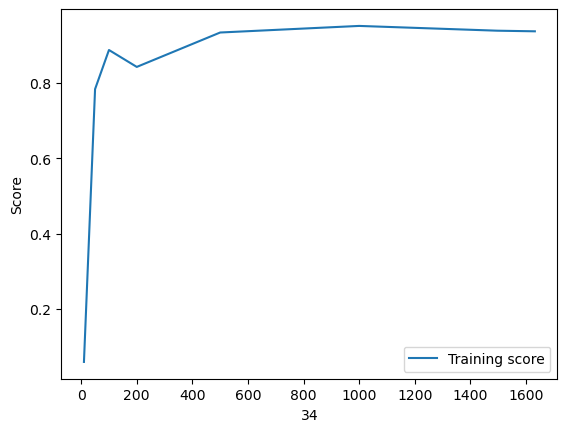

In [32]:
xgb_params = pd.read_csv('./parameters\hyperparameter_xgb_split2_lbw.csv')
i = 33
bnum = 34

y_train = final_train_df.loc[final_train_df.building_number == bnum, 'power_consumption']
x_train = final_train_df.loc[final_train_df.building_number == bnum].drop(['power_consumption'], axis=1)

xgb_reg = XGBRegressor(n_estimators = xgb_params.iloc[i,7], eta = xgb_params.iloc[i,1], min_child_weight = xgb_params.iloc[i,2], 
                    max_depth = xgb_params.iloc[i,3], colsample_bytree = xgb_params.iloc[i,4], 
                    subsample = xgb_params.iloc[i,5], seed=seed)
if xgb_params.iloc[0,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb_reg.set_params(**{'objective':weighted_mse(xgb_params.iloc[0,6])})


# 학습 데이터 크기 지정 (여기서는 일부 데이터만 사용하도록 설정)
train_sizes = [10, 50, 100, 200, 500, 1000, 1497, 1632]

# 학습 곡선 그리기
train_sizes, train_scores, valid_scores = learning_curve(xgb_reg, x_train, y_train, train_sizes=train_sizes, cv=5)

# 각 학습 데이터 크기에 따른 평균 성능 계산
mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# 학습 곡선 그리기
plt.plot(train_sizes, mean_train_scores, label='Training score')
plt.plot(train_sizes, mean_valid_scores, label='Validation score')
plt.xlabel(f'{bnum}')
plt.ylabel('Score')
plt.legend()
plt.show()

In [17]:

miss_data = pd.DataFrame({'building_number': missfit_building, 'SMAPE': scores})
miss_data_before = pd.read_csv('miss_data_split2_lbw.csv')
miss_data_before_10 = miss_data_before.loc[miss_data_before.SMAPE > 10]

miss_data = np.array(miss_data)
miss_data_before_10 = np.array(miss_data_before_10)
check = miss_data - miss_data_before_10
print(np.mean(check))

0.11096493881023539


In [30]:
# pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
# i = bnum
# for seed in [0,1,2,3,4,5]: # 각 시드별 예측
#     y_train = merged_train_df.loc[merged_train_df.building_number == i, 'power_consumption']
#     x_train = merged_train_df.loc[merged_train_df.building_number == i].drop(['power_consumption'], axis=1)
#     y_test = merged_valid_df.loc[merged_valid_df.building_number == i, 'power_consumption']
#     x_test = merged_valid_df.loc[merged_valid_df.building_number == i].drop(['power_consumption'], axis=1)

#     xgb = XGBRegressor(seed = seed, n_estimators = xgb_params.iloc[i-1, 7], eta = 0.01,
#                         min_child_weight = xgb_params.iloc[i-1, 2], max_depth = xgb_params.iloc[i-1, 3],
#                         colsample_bytree=xgb_params.iloc[i-1, 4], subsample=xgb_params.iloc[i-1, 5])

#     if xgb_params.iloc[i-1,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
#         xgb.set_params(**{'objective':weighted_mse(xgb_params.iloc[i-1,6])})

#     xgb.fit(x_train, y_train)
#     y_pred = xgb.predict(x_test)
#     pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기

# pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
# pred_np = pred.to_numpy()
# y_test_np = y_test.to_numpy()
# score = SMAPE(y_test_np, pred_np)

# print(score)

1.494984194488569
